<a href="https://colab.research.google.com/github/janepu47/229352/blob/main/%E0%B8%AA%E0%B8%B3%E0%B9%80%E0%B8%99%E0%B8%B2%E0%B8%82%E0%B8%AD%E0%B8%87_Lab09_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

In [2]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [4]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

### HYperparameters
1. learning rate
2. Batch size
3. Epoch

In [5]:
train_size = int(0.8 * len(dataset))   #แบ่งข้อมูล 80% อยู่ในเทรนนิ่งเซท
val_size = len(dataset) - train_size   #ข้อมูลใน validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [6]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [7]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [8]:
train_loader

In [9]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


In [10]:
X[0]

tensor([[[0.6157, 0.6196, 0.6235,  ..., 0.4980, 0.5098, 0.5216],
         [0.6275, 0.6275, 0.6353,  ..., 0.4941, 0.4980, 0.5098],
         [0.6275, 0.6392, 0.6431,  ..., 0.4824, 0.4902, 0.4980],
         ...,
         [0.4471, 0.4235, 0.3765,  ..., 0.6549, 0.6588, 0.6627],
         [0.4000, 0.3765, 0.3569,  ..., 0.6588, 0.6667, 0.6667],
         [0.3843, 0.3843, 0.3804,  ..., 0.6627, 0.6667, 0.6706]],

        [[0.6431, 0.6431, 0.6431,  ..., 0.5373, 0.5569, 0.5765],
         [0.6549, 0.6588, 0.6627,  ..., 0.5333, 0.5451, 0.5647],
         [0.6627, 0.6745, 0.6745,  ..., 0.5255, 0.5412, 0.5529],
         ...,
         [0.2980, 0.2824, 0.2431,  ..., 0.6275, 0.6275, 0.6353],
         [0.2627, 0.2510, 0.2353,  ..., 0.6314, 0.6353, 0.6314],
         [0.2471, 0.2549, 0.2588,  ..., 0.6353, 0.6392, 0.6431]],

        [[0.6745, 0.6745, 0.6745,  ..., 0.5725, 0.5922, 0.6039],
         [0.6863, 0.6902, 0.6941,  ..., 0.5686, 0.5804, 0.5961],
         [0.6941, 0.7059, 0.7020,  ..., 0.5647, 0.5765, 0.

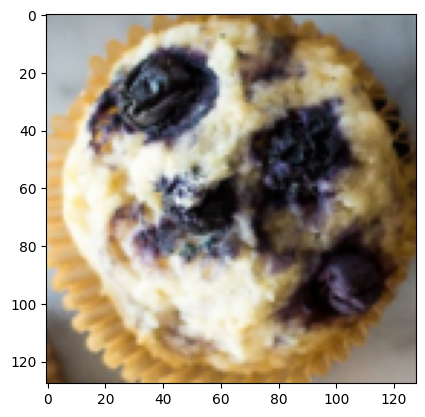

In [11]:
plt.imshow(X[0].numpy().transpose(1,2,0))

In [12]:
y

tensor([1, 1, 1, 1, 0, 1, 0, 1, 0, 1])

#### Visualize the first four images in the batch

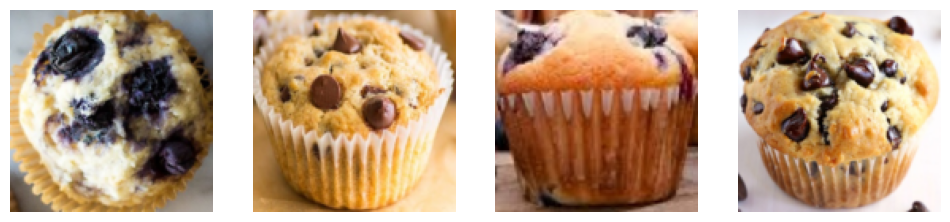

tensor([1, 1, 1, 1])


In [13]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  
  
[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [14]:
class SimpleLogisticRegression(nn.Module):
    def __init__(self):
        super(SimpleLogisticRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128*128*3, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        x = self.activation(x)
        return x

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [15]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

#### Manually setting initial weights to zero for demonstration

In [16]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [17]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [18]:
learning_rate = 1e-3

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [19]:
train_batches = iter(train_loader)
X, y = next(train_batches)

#### Make a prediction on the minibatch (Forward pass)

In [20]:
y_hat = model(X)

y_hat = y_hat[:, 0]
y = y.to(torch.float32)



#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [21]:
# Compute the loss
loss = criterion(y_hat, y)
train_losses.append(loss.item())


In [22]:
train_losses

[0.6931471824645996]

#### Calculate the gradient (Backward pass)

In [23]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
loss.backward()


In [24]:
for param in model.parameters():
  print(param)

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [25]:
for param in model.parameters():
  print(param.grad)

tensor([[0.0531, 0.0504, 0.0502,  ..., 0.0833, 0.0794, 0.0725]])
tensor([0.2000])


#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [26]:
# Manually update the weights using the gradient descent rule
with torch.no_grad():
    for param in model.parameters():
        param -= learning_rate * param.grad


# Zero the gradients after updating
model.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [27]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

In [28]:
print(train_losses)
print(val_losses)

[0.6931471824645996]
[1.0187879800796509]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

Epoch [1/20], Train Loss: 0.7325, Train Acc: 46.88%, Val Loss: 0.7527, Val Acc: 41.67%
Epoch [2/20], Train Loss: 0.7213, Train Acc: 46.88%, Val Loss: 0.7447, Val Acc: 41.67%
Epoch [3/20], Train Loss: 0.7187, Train Acc: 46.88%, Val Loss: 0.7388, Val Acc: 41.67%
Epoch [4/20], Train Loss: 0.7143, Train Acc: 46.88%, Val Loss: 0.7345, Val Acc: 41.67%
Epoch [5/20], Train Loss: 0.7150, Train Acc: 46.88%, Val Loss: 0.7305, Val Acc: 41.67%
Epoch [6/20], Train Loss: 0.7135, Train Acc: 46.88%, Val Loss: 0.7276, Val Acc: 41.67%
Epoch [7/20], Train Loss: 0.7107, Train Acc: 46.88%, Val Loss: 0.7252, Val Acc: 41.67%
Epoch [8/20], Train Loss: 0.7037, Train Acc: 46.88%, Val Loss: 0.7240, Val Acc: 41.67%
Epoch [9/20], Train Loss: 0.7084, Train Acc: 46.88%, Val Loss: 0.7223, Val Acc: 41.67%
Epoch [10/20], Train Loss: 0.7076, Train Acc: 46.88%, Val Loss: 0.7208, Val Acc: 41.67%
Epoch [11/20], Train Loss: 0.7046, Train Acc: 46.88%, Val Loss: 0.7197, Val Acc: 41.67%
Epoch [12/20], Train Loss: 0.7060, Train 

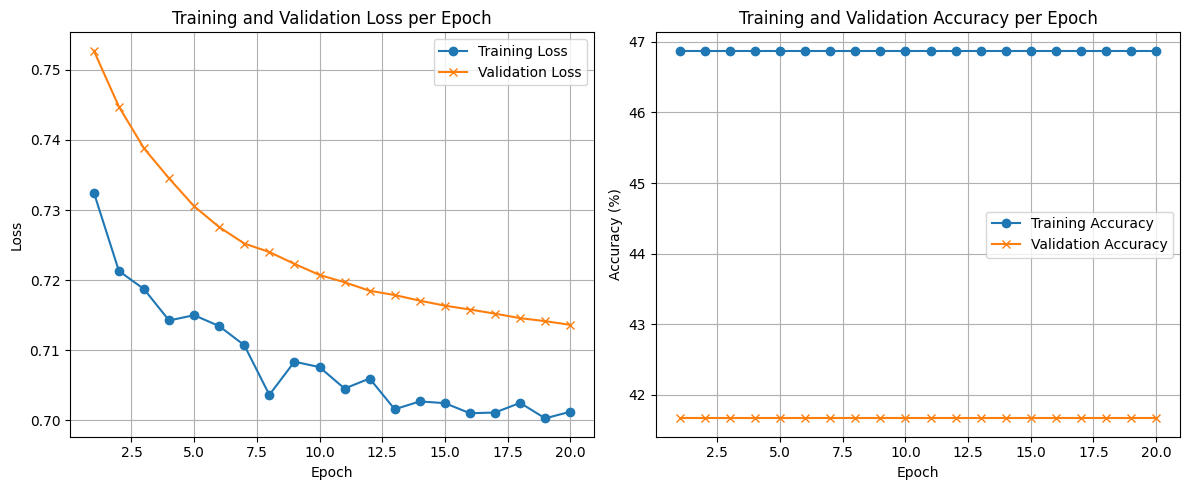

In [29]:
model = SimpleLogisticRegression() # Use the defined class
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification

# Initialize weights to zero (optional)
with torch.no_grad():
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            layer.weight.zero_()
            layer.bias.zero_()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

learning_rate = 1e-4

for epoch in range(20):
    # Training phase
    model.train()
    epoch_train_loss = 0.0
    train_correct = 0
    train_total = 0

    for X, y in train_loader:
        y_hat = model(X)  # forward pass
        y = y.to(torch.float32).unsqueeze(1) # Ensure target shape matches output shape

        loss = criterion(y_hat, y)
        epoch_train_loss += loss.item()

        # Calculate accuracy
        predicted = (torch.sigmoid(y_hat) > 0.5).float() # Apply sigmoid and threshold
        train_total += y.size(0)
        train_correct += (predicted == y).sum().item()

        loss.backward()  # backward pass

        # Manual gradient descent
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad

        # Zero the gradients after updating
        model.zero_grad()

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    epoch_val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in val_loader:
            y_hat = model(X)
            y = y.to(torch.float32).unsqueeze(1) # Ensure target shape matches output shape

            val_loss = criterion(y_hat, y)
            epoch_val_loss += val_loss.item()

            # Calculate validation accuracy
            predicted = (torch.sigmoid(y_hat) > 0.5).float() # Apply sigmoid and threshold
            val_total += y.size(0)
            val_correct += (predicted == y).sum().item()


    avg_val_loss = epoch_val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/20], '
          f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

# Plot the training and validation loss
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, marker='x', label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [30]:
class SimpleLogisticRegression(nn.Module):
    def __init__(self):
        super(SimpleLogisticRegression, self).__init__()
        #(B, C, H, W) = (10, 3, 128, 128)
        self.flatten = nn.Flatten()  #(10, 49152)
        self.linear1 = nn.Linear(128*128*3, 128)     #(10, 128)
        self.act1 = nn.ReLU()

        self.linear2 = nn.Linear(128, 64)
        self.act2 = nn.ReLU()

        self.linear3 = nn.Linear(64, 32)
        self.act3 = nn.ReLU()

        self.output = nn.Linear(32, 1)
        self.activation = nn.Sigmoid()      #(10, 1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.linear3(x)
        x = self.act3(x)
        x = self.output(x)
        x = self.activation(x)
        return x

In [32]:
with torch.no_grad():
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            layer.weight.zero_()
            layer.bias.zero_()

learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
results = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    model = SimpleLogisticRegression() # Re-initialize model for each learning rate
    criterion = nn.BCEWithLogitsLoss() # Use BCEWithLogitsLoss for binary classification

    # Initialize weights to zero (optional) - moved inside the lr loop
    with torch.no_grad():
        for layer in model.modules():
            if isinstance(layer, nn.Linear):
                layer.weight.zero_()
                layer.bias.zero_()

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []


    for epoch in range(20):
        # Training phase
        model.train()
        epoch_train_loss = 0.0
        train_correct = 0
        train_total = 0

        for X, y in train_loader:
            y_hat = model(X)  # forward pass (output ผ่าน sigmoid แล้ว)
            y = y.to(torch.float32).unsqueeze(1)  # Ensure target shape matches output shape

            loss = criterion(y_hat, y)
            epoch_train_loss += loss.item()

            # Calculate accuracy - ไม่ต้องใช้ sigmoid อีกครั้ง
            predicted = (torch.sigmoid(y_hat) > 0.5).float()  # y_hat ผ่าน sigmoid แล้ว
            train_total += y.size(0)
            train_correct += (predicted == y).sum().item()

            loss.backward()  # backward pass

            # Manual gradient descent
            with torch.no_grad():
                for param in model.parameters():
                    param -= lr * param.grad  # ใช้ lr จาก loop

            # Zero the gradients after updating
            model.zero_grad()

        # Calculate average training loss and accuracy for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for X, y in val_loader:
                y_hat = model(X)
                y = y.to(torch.float32).unsqueeze(1)

                val_loss = criterion(y_hat, y)
                epoch_val_loss += val_loss.item()

                # Calculate validation accuracy
                predicted = (torch.sigmoid(y_hat) > 0.5).float() # ไม่ต้องใช้ sigmoid อีกครั้ง
                val_total += y.size(0)
                val_correct += (predicted == y).sum().item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'  Epoch [{epoch+1}/20], '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


    results[lr] = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }

print("\n=== Training Complete ===")


Training with learning rate: 0.01
  Epoch [1/20], Train Loss: 0.7390, Train Acc: 46.88%, Val Loss: 0.7655, Val Acc: 41.67%
  Epoch [2/20], Train Loss: 0.7455, Train Acc: 46.88%, Val Loss: 0.7653, Val Acc: 41.67%
  Epoch [3/20], Train Loss: 0.7387, Train Acc: 46.88%, Val Loss: 0.7651, Val Acc: 41.67%
  Epoch [4/20], Train Loss: 0.7386, Train Acc: 46.88%, Val Loss: 0.7649, Val Acc: 41.67%
  Epoch [5/20], Train Loss: 0.7384, Train Acc: 46.88%, Val Loss: 0.7648, Val Acc: 41.67%
  Epoch [6/20], Train Loss: 0.7383, Train Acc: 46.88%, Val Loss: 0.7646, Val Acc: 41.67%
  Epoch [7/20], Train Loss: 0.7447, Train Acc: 46.88%, Val Loss: 0.7643, Val Acc: 41.67%
  Epoch [8/20], Train Loss: 0.7380, Train Acc: 46.88%, Val Loss: 0.7642, Val Acc: 41.67%
  Epoch [9/20], Train Loss: 0.7378, Train Acc: 46.88%, Val Loss: 0.7640, Val Acc: 41.67%
  Epoch [10/20], Train Loss: 0.7312, Train Acc: 46.88%, Val Loss: 0.7638, Val Acc: 41.67%
  Epoch [11/20], Train Loss: 0.7376, Train Acc: 46.88%, Val Loss: 0.7636, 

2.1 What value of learning rate do you think is the best? Please explain your reason
- 1e-3 (0.001) เพราะ ได้ accuracy สูงทั้ง training และ validation

2.2 What happens to the training losses if your learning rate is too large?
- loss อาจเพิ่มขึ้น และอาจเกิด overfitting

2.3 What happens to the training losses if your learning rate is too small?
- เรียนรู้ช้ามาก loss ลดลงทีละน้อยมาก และอาจเกิด underfitting

In [33]:
# Use this code to calculate test accuracy
with torch.no_grad():
  test_batches = iter(test_loader)
  X, y = next(test_batches)
  y_hat = model(X)
  y_hat = y_hat[:, 0]
  y_hat = (y_hat > 0.5).float()  # the predictions
  # compute accuracy
  correct = (y_hat == y.to(torch.float32)).sum().item()
  total = y.size(0)
  accuracy = 100 * correct / total
  print(f"Test accuracy: {accuracy:.2f}%")

Test accuracy: 56.67%
